In [12]:
import numpy as np
from itertools import product
from scipy.optimize import fsolve


class betrand_model(object):

    def __init__(self, **kwargs):
        """Initialize game with default values"""
        # Default properties
        self.numPlayers = 2
        self.alpha = kwargs.get('alpha', 0.15)
        self.beta = kwargs.get('beta', 4e-6)
        self.delta = kwargs.get('delta', 0.95)
        
        self.eps = kwargs.get('eps',0.5)
        
        self.c = kwargs.get('c', 1)
        self.a = kwargs.get('a', 2)
        self.a0 = kwargs.get('a0', 0)
        self.mu = kwargs.get('mu', 0.25)
        self.penalty = kwargs.get('penalty',-1)
        self.reward = kwargs.get('reward',1)
        self.k = kwargs.get('k',15)
        self.numiActions = self.k ** 2
        self.numActions = self.numiActions ** self.numPlayers


        # Derived properties
        self.indexActions = self.init_indexActions()
        self.sdim, self.s0 = self.init_state()
        self.p_minmax_cost_1 = self.compute_p_competitive_monopoly(c = 1)
        self.init_actions()
        
        self.Profits,self.Penalty = self.init_Profits()
        self.Q = self.init_Q()
        self.cActions = self.init_cActions()

        
    def demand(self, p):
        e = np.exp((self.a - p) / self.mu)
        d = e / (np.sum(e) + np.exp(self.a0 / self.mu))
        return d

    
    def foc(self, p, c):
        d = self.demand(p)
        zero = 1 - (p - c) * (1 - d) / self.mu
        return np.squeeze(zero)

    
    def foc_monopoly(self, p, c):
        d = self.demand(p)
        d1 = np.flip(d)
        p1 = np.flip(p)
        zero = 1 - (p - c) * (1 - d) / self.mu + (p1 - c) * d1 / self.mu
        return np.squeeze(zero)
    
    
    def foc1_monopoly(self,p,c):
        zero = -p + c + self.mu*(1+np.exp((self.a-p-self.a0)/self.mu))
        return zero
    
    def compute_p_monopoly_1(self,c):
        p0 = c
        p_monopoly = fsolve(self.foc1_monopoly,p0,args = (c,))
        return p_monopoly

    
    def compute_p_competitive_monopoly(self, c):
        p0 = np.ones((1, self.numPlayers)) * 1 * c
        p_competitive = fsolve(self.foc, p0,args = (c,))
        p_monopoly = fsolve(self.foc_monopoly, p0,args = (c,))
        return p_competitive, p_monopoly

    
    
    def init_actions(self):
        a = np.linspace(min(self.p_minmax_cost_1[0]), max(self.p_minmax_cost_1[1]), self.k - 2)
        delta = a[1] - a[0]
        A = np.linspace(min(a) - delta, max(a) + delta, self.k)
        self.player_actions = A
        self.player_cost = self.player_actions - self.mu*(1+1/(self.numPlayers-1 + \
                                      np.exp((self.a0-self.a+self.player_actions)/self.mu)))
        self.player_cost[np.abs(self.player_cost-self.c)<1e-5] = self.c
        self.buyer_action_list = np.array(list(product(A, repeat=2)))
        self.buyer_cost_list = np.array(list(product(self.player_cost, repeat=2)))
        self.seller_action_list = np.array(list(product(A, repeat=2)))
        self.seller_cost_list = np.array(list(product(self.player_cost, repeat=2)))
    
    
    def init_indexActions(self):
        
        indexActions = []
        for i in range(self.numActions):
            
            indexActions.append(self.convertNumberBase(i, self.numiActions, self.numPlayers))
            
        indexActions = np.array(indexActions)
        
        return indexActions

    
    def init_state(self):
        sdim = (self.k, self.k)
        s0 = np.zeros(len(sdim)).astype(int)
        return sdim, s0
    
    
    def init_cActions(self):
        """Initialize cActions (used for q-learning)"""
        
        x = np.arange(self.numPlayers - 1, -1, -1)
        cActions = self.numiActions ** x
        
        return cActions

    
    def compute_profits(self, p, c):
        d = self.demand(p)
        pi = (p - c) * d
        return pi

    
    def init_Profits(self):
        Profits = np.zeros((2,self.numActions, self.numPlayers))
        Penalty = np.zeros((2,self.numActions, self.numPlayers))        
        Actions = np.zeros((self.numActions, 4))
        
        for i in range(self.numActions):
            b = int(self.indexActions[i][0])
            s = int(self.indexActions[i][1])
            
            cb,cb_a = self.buyer_cost_list[b]
            cs,cs_a = self.seller_cost_list[s]
            vb,vb_a = self.buyer_action_list[b]
            vs,vs_a = self.seller_action_list[s]
            penalb1 = 0
            penals1 = 0
            penalb2 = 0
            penals2 = 0
            pb1 = 0
            ps1 = 0
            pb2 = 0
            ps2 = 0
            
            Actions[i] = cb, cb_a,cs,cs_a
            
        #No mechanism
            if cb == cs:
                p = np.array([vb,vs])

                c = np.array([1,1])
                pb1,ps1 = self.compute_profits(p,c)
                
            else:
                pb1 += self.penalty
                ps1 += self.penalty
                penals1 += self.penalty
                penalb1 += self.penalty
                
                
                price_b = self.compute_p_monopoly_1(c = cb_a)[0]
                p = np.array([price_b,100000])
                c = np.array([1,1])   
                pb2,ps2_ = self.compute_profits(p,c)


                price_s = self.compute_p_monopoly_1(c = cs_a)[0]
                p = np.array([100000,price_s])
                c = np.array([1,1])                
                pb2_,ps2 = self.compute_profits(p,c)                


                if cb == cs_a:
                    penalb1 += self.reward
                    pb1 += self.reward

                else:
                    penalb1 +=self.penalty
                    pb1 += self.penalty

                if cs == cb_a:
                    penals1 += self.reward
                    ps1 += self.reward

                else:
                    penals1 +=self.penalty
                    ps1 += self.penalty


#             print('cb:',format(cb,'.2f'),'     cb_a:',format(cb_a,'.2f'),'     cs:',format(cs,'.2f'),\
#             '     cs_a:',format(cs_a,'.2f'),'     pb:',format(pb,'.2f'),'     ps:',format(ps,'.2f'))

            Profits[1][i] = [pb1, ps1]
            Penalty[1][i] = [penalb1,penals1]
            

        return Profits,Penalty
            
            

    
    def init_Q(self):
        Q = np.zeros((self.numActions, self.numiActions, self.numPlayers))
        for iReport in range(self.numiActions):
            
            den = np.count_nonzero(self.indexActions == iReport,axis = 0,keepdims = True) * (1 - self.delta)
            Q[:, iReport,:] = np.ma.array((1 - self.eps)*self.Profits[0]+self.eps * self.Profits[1],
                                mask=(self.indexActions != iReport)).sum(axis = 0) / den
        return Q
    
    
    @staticmethod
    def convertNumberBase(n, b, l):
        '''
        Converts an integer n from base 10 to base b,
        generating a vector of integers of length l
        '''
        tmp = n
        ans = np.zeros(l)
        for i in range(1, l+1):
            ans[l-i] = int(tmp % b)
            tmp = np.floor(tmp/b)
        return ans



In [13]:
b_model = betrand_model()


In [4]:
b_model.Profits.shape

(50625, 2)

In [276]:
import numpy as np

# from SRModel import SRModel

    
class betrand_Qlearning(object):
    '''
        Qlearning based on SR model
    '''
    def __init__(self, **kwargs):

        self.delta = kwargs.get('delta', 0.95)
        
        self.reward = kwargs.get('reward',50)
        self.penalty = kwargs.get('penalty',-50)
        
        self.eps = kwargs.get('eps',0.5)

        self.convergedtime = kwargs.get('convergedtime',500)
        self.numSessions = kwargs.get('numSessions',1)
        self.maxIters = kwargs.get('maxIters',100000)
        self.true_value_index = kwargs.get('true_value',1)

        self.game = betrand_model(delta = self.delta,true_value = self.true_value_index,\
                                   reward = self.reward,penalty = self.penalty,eps = self.eps)
        self.alpha = kwargs.get('alpha', 0.25) * np.ones(self.game.numPlayers)
        self.beta = kwargs.get('beta', 0.0005) * np.ones(self.game.numPlayers)
        self.initial_state = kwargs.get('initial_state',10)

        
        
        self.delta = kwargs.get('delta',0.95)
        
               
    def computePPrime(self, strategyPrime, iters):
        
        pPrime = np.zeros(self.game.numPlayers)
        #  Greedy with probability 1-epsilon, with exponentially decreasing epsilon
        
        for iPlayer in range(self.game.numPlayers):
            
            if np.random.uniform(0,1) < np.exp(-self.beta[iPlayer]*iters):

                pPrime[iPlayer] = np.floor(self.game.numiActions*np.random.uniform(0,1))
            else:
                pPrime[iPlayer] = strategyPrime[iPlayer]
                
        return pPrime


    def q_learning(self):

        # Initializing various quantities

        indexStrategies = np.zeros((self.game.numPlayers,self.numSessions))

        indexConverge = np.zeros((self.game.numPlayers,self.numSessions))
        
        self.profit_list = np.full((self.numSessions,self.maxIters,self.game.numPlayers),np.nan)
        self.penalty_list = np.full((self.numSessions,self.maxIters,self.game.numPlayers),np.nan)

        # Loop over numSessions
        for iSession in range(self.numSessions):
            
            
            # Learning Phase
            
            # Initialization
            self.Q = self.game.Q.copy()
            self.strategyPrime = np.zeros(self.game.numPlayers)
            maxVal = np.zeros(self.game.numPlayers)
            
            strategyPrime = np.floor(np.random.uniform(0,1,(2))*self.game.numiActions)   

            state = int(np.sum(self.game.cActions*strategyPrime)) 

            
            # Loop
            itersInStrategy = 0
            convergedSession = -1
            
            strategyFix = np.zeros(self.game.numPlayers)
            
            for iters in range(self.maxIters):
                
                # Iterations counter
                
                for iPlayer in range(self.game.numPlayers):
                    
                    temp_q = self.Q[state,:,iPlayer]
                    #print(iters,temp_q)
                    maxVal[iPlayer] = np.max(temp_q)
                    #print(iters,maxVal)

                    strategyPrimeList = np.where(temp_q == maxVal[iPlayer])[0]
                    #print(iters,strategyPrimeList)
                    
                    u = np.random.uniform(0, 1)
                    strategyPrime[iPlayer] = strategyPrimeList[int(len(strategyPrimeList)*u)]
     
                state1 = int(np.sum(self.game.cActions*strategyPrime))     
                pPrime = self.computePPrime(strategyPrime, iters)
                state2 = int(np.sum(self.game.cActions*pPrime)) 

                
                maxVal = np.max(self.Q[state1,:,:],axis = 0)
                
                for iPlayer in range(self.game.numPlayers):
                    
                    # Q matrices and strategies update
                    if np.random.uniform(0, 1) < 1 - self.game.eps:
                        profits = self.game.Profits[0][state2, iPlayer]
                    else:
                        profits = self.game.Profits[1][state2, iPlayer]
                        
                    oldq = self.Q[state, int(pPrime[iPlayer]), iPlayer]
                    newq = oldq + self.alpha[iPlayer] * (profits+ \
                                                self.delta * maxVal[iPlayer] - oldq)
                    #print('pppppp',state1)
                    self.Q[state, int(pPrime[iPlayer]), iPlayer] = newq
                    
                state = state1
                #print(strategyPrime,pPrime)
                # Assessing convergence
                #print(strategyPrime,pPrime)
                vb, vb_a = self.game.buyer_action_list[int(strategyPrime[0])]
                vs, vs_a = self.game.seller_action_list[int(strategyPrime[1])]
                
                vb_1, vb_a_1 = self.game.buyer_action_list[int(pPrime[0])]
                vs_1, vs_a_1 = self.game.seller_action_list[int(pPrime[1])]  
                if vb == vb_1 and vs == vs_1:
                    itersInStrategy = itersInStrategy + 1
                else:
                    itersInStrategy = 1

                # Check for convergence in strategy
                if convergedSession == -1:
                    # Maximum number of iterations exceeded
                    if iters >= self.maxIters - 1:
                        convergedSession = 0


                    if itersInStrategy == self.convergedtime:
                        convergedSession = 1

                    strategyFix = strategyPrime.copy()               #testing

                # Check for loop exit criteria
                if convergedSession != -1:
                    break
                # if no converge yet, update and iterate
    
            indexConverge[:,iSession] = (convergedSession, iters)
            indexStrategies[:,iSession] = strategyFix
            self.indexConverge = indexConverge
            self.indexStrategies = indexStrategies
            #print(iSession,convergedSession)

        return indexConverge, indexStrategies



    

In [289]:
K = betrand_Qlearning(numSessions = 100,delta = 0.95,alpha = 0.25,beta = 0.0001,
                 true_value = 1,penalty = -1,reward = 1,eps = 0.5,
                 convergedtime = 500,maxIters = 1000000)
R = K.q_learning()



print(R)


(array([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0

In [290]:
lll = np.array([[196., 196., 111., 136., 201., 196., 196., 196.,  67., 151., 196.,
        140., 196.,  35., 203.,  80., 217., 199., 196., 155., 143.,  64.,
        219., 181., 196., 196., 196., 224., 196.,  60., 208., 196., 208.,
        196., 196., 217.,  82., 196., 196., 196., 223., 196., 196., 109.,
         77., 196., 140., 196., 210., 210., 196., 204., 196., 170., 196.,
        196., 152., 206.,  63., 198., 124., 196.,   5., 200., 196., 196.,
        196.,  22.,  99., 196.,  79., 196., 196., 216., 196., 196., 127.,
        203.,  32.,  90., 156., 196.,  95., 196., 171., 196.,  77.,  43.,
        172.,  84.,  55.,  19., 196., 130., 196.,  30.,  32.,  34., 151.,
         54.],
       [196., 196., 109., 137., 204., 196., 196., 196.,  65., 156., 196.,
         36., 196.,  43., 196.,  85., 211., 195., 196., 153., 144.,  69.,
        223.,   8., 196.,  14., 196., 216., 196.,  64., 206., 195., 196.,
        196., 196., 216.,  79., 196., 196., 196.,  92., 196., 196., 117.,
         77., 196., 138., 196., 210., 210., 196., 199., 196., 171., 196.,
        201.,  50., 195.,  62., 196., 120., 208.,   5., 196., 196., 196.,
        196.,  25., 101., 203., 146., 196., 196.,  20., 196., 196., 134.,
        196.,  37.,  96., 155., 196., 100., 196., 172., 196., 196., 203.,
        166.,  87., 196.,  15., 196., 127., 196.,  36.,  34., 142., 161.,
         51.]])

In [291]:
llll = lll//15
index =index0 = index1 = index2 = index3 = index4 =index5 = \
    index6 = index7 = index8 = index9 =index10 = index11 = index12 = index13 = index14 = 0
for i in range(100):
    if llll[1,i] == llll[0,i]:
        index +=1
        if llll[1,i] == 0:
            index0 +=1
        if llll[1,i] == 1:
            index1 +=1
        if llll[1,i] == 2:
            index2 +=1
        if llll[1,i] == 3:
            index3 +=1
        if llll[1,i] == 4:
            index4 +=1
        if llll[1,i] == 5:
            index5 +=1
        if llll[1,i] == 6:
            index6 +=1
        if llll[1,i] == 7:
            index7 +=1
        if llll[1,i] == 8:
            index8 +=1
        if llll[1,i] == 9:
            index9 +=1
        if llll[1,i] == 10:
            index10 +=1
        if llll[1,i] == 11:
            index11 +=1
        if llll[1,i] == 12:
            index12 +=1
        if llll[1,i] == 13:
            index13 +=1
        if llll[1,i] == 14:
            index14 +=1

Text(0.5, 1.0, '0.89')

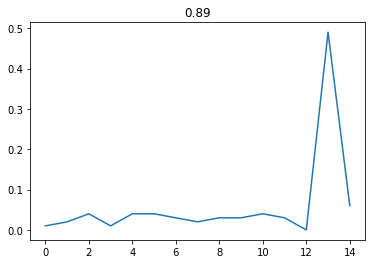

In [292]:
import matplotlib.pyplot as plt
plt.plot(range(0,15),np.array([index0/100,index1/100,index2/100,index3/100,index4/100,index5/100,index6/100,index7/100,index8/100,\
index9/100,index10/100,index11/100,index12/100,index13/100,index14/100]))
plt.title('{:.2f}'.format(index/100))

In [288]:
K.game.player_cost

array([0.95889993, 1.        , 1.04152937, 1.08352162, 1.1260071 ,
       1.16901106, 1.21255145, 1.25663669, 1.30126337, 1.34641424,
       1.39205666, 1.43814179, 1.48460469, 1.53136563, 1.57833246])

1.9249809190177618

In [89]:
        for s in b_model.action_list:
            print(b_model.compute_profits(s))

[0.20682553 0.20682553]
[0.22155186 0.2070539 ]
[0.23600529 0.20482047]
[0.2500352  0.20041303]
[0.26350889 0.19415033]
[0.27631598 0.18636658]
[0.28837091 0.17739646]
[0.29961382 0.16756186]
[0.31000971 0.15716109]
[0.31954627 0.14646121]
[0.32823096 0.13569327]
[0.3360875  0.12505043]
[0.34315225 0.11468832]
[0.34947076 0.10472711]
[0.35509455 0.0952549 ]
[0.2070539  0.22155186]
[0.22292666 0.22292666]
[0.23866335 0.22163041]
[0.25409097 0.21792449]
[0.26905004 0.2121133 ]
[0.2834008 0.2045291]
[0.29702771 0.19551608]
[0.30984202 0.18541533]
[0.32178241 0.17455169]
[0.33281401 0.16322342]
[0.34292597 0.15169495]
[0.35212819 0.14019278]
[0.36044761 0.12890402]
[0.36792429 0.11797738]
[0.37460776 0.10752566]
[0.20482047 0.23600529]
[0.22163041 0.23866335]
[0.23846389 0.23846389]
[0.25513124 0.23563339]
[0.27145021 0.23045249]
[0.2872537  0.22324207]
[0.3023962 0.2143474]
[0.31675832 0.20412196]
[0.33024927 0.19291233]
[0.34280734 0.18104534]
[0.35439862 0.16881816]
[0.36501435 0.156491

In [90]:
b_model.compute_profits(b_model.action_list)

array([[0.00226462, 0.00226462],
       [0.00226462, 0.00211642],
       [0.00226462, 0.00196538],
       [0.00226462, 0.00181518],
       [0.00226462, 0.00166854],
       [0.00226462, 0.00152741],
       [0.00226462, 0.00139312],
       [0.00226462, 0.00126651],
       [0.00226462, 0.00114806],
       [0.00226462, 0.00103797],
       [0.00226462, 0.00093621],
       [0.00226462, 0.00084261],
       [0.00226462, 0.00075688],
       [0.00226462, 0.00067865],
       [0.00226462, 0.00060749],
       [0.00211642, 0.00226462],
       [0.00211642, 0.00211642],
       [0.00211642, 0.00196538],
       [0.00211642, 0.00181518],
       [0.00211642, 0.00166854],
       [0.00211642, 0.00152741],
       [0.00211642, 0.00139312],
       [0.00211642, 0.00126651],
       [0.00211642, 0.00114806],
       [0.00211642, 0.00103797],
       [0.00211642, 0.00093621],
       [0.00211642, 0.00084261],
       [0.00211642, 0.00075688],
       [0.00211642, 0.00067865],
       [0.00211642, 0.00060749],
       [0.

In [89]:
b_model.indexActions.shape

(256, 2)

In [90]:
b_model.Profits.shape

(256, 2)

In [95]:
for i in range(K.game.numActions):
    print('____________________________________________________________________')
    b = int(K.game.indexActions[i][0])
    s = int(K.game.indexActions[i][1])

    cb,cb_a = K.game.buyer_cost_list[b]
    cs,cs_a = K.game.seller_cost_list[s]
    vb,vb_a = K.game.buyer_action_list[b]
    vs,vs_a = K.game.seller_action_list[s]
    penalb = 0
    penals = 0
    
    print('cb:',cb,'cs:',cs,'cb_a:',cb_a,'cs_a:',cs_a)
    print('buyer profits:',K.game.Profits[i][0])
    print('seller profits:',K.game.Profits[i][1])

____________________________________________________________________
cb: 0.5257528425553404 cs: 0.5257528425553404 cb_a: 0.5257528425553404 cs_a: 0.5257528425553404
buyer profits: 0.010333329880936354
seller profits: 0.010333329880936354
____________________________________________________________________
cb: 0.5257528425553404 cs: 0.5257528425553404 cb_a: 0.5257528425553404 cs_a: 1.0
buyer profits: 0.010333329880936354
seller profits: 0.010333329880936354
____________________________________________________________________
cb: 0.5257528425553404 cs: 0.5257528425553404 cb_a: 0.5257528425553404 cs_a: 1.531365625336648
buyer profits: 0.010333329880936354
seller profits: 0.010333329880936354
____________________________________________________________________
cb: 0.5257528425553404 cs: 0.5257528425553404 cb_a: 0.5257528425553404 cs_a: 2.0817315522524162
buyer profits: 0.010333329880936354
seller profits: 0.010333329880936354
________________________________________________________________

cb: 2.0817315522524162 cs: 2.0817315522524162 cb_a: 0.5257528425553404 cs_a: 2.0817315522524162
buyer profits: 0.21125607988518133
seller profits: 0.21125607988518133
____________________________________________________________________
cb: 2.0817315522524162 cs: 0.5257528425553404 cb_a: 1.0 cs_a: 0.5257528425553404
buyer profits: -1.7343171873316758
seller profits: -1.7241563571834062
____________________________________________________________________
cb: 2.0817315522524162 cs: 0.5257528425553404 cb_a: 1.0 cs_a: 1.0
buyer profits: -1.7343171873316758
seller profits: -1.7343171873316758
____________________________________________________________________
cb: 2.0817315522524162 cs: 0.5257528425553404 cb_a: 1.0 cs_a: 1.531365625336648
buyer profits: -1.7343171873316758
seller profits: -1.7816257450174264
____________________________________________________________________
cb: 2.0817315522524162 cs: 0.5257528425553404 cb_a: 1.0 cs_a: 2.0817315522524162
buyer profits: 0.7656828126683242
se

In [122]:
def compute_p_competitive_monopoly(c):
    p0 = np.ones((1, 2)) * 1 * c
    p_competitive = fsolve(K.game.foc, p0,args = (c,))
    p_monopoly = fsolve(K.game.foc_monopoly, p0,args = (c,))
    return p_competitive, p_monopoly

In [123]:
compute_p_competitive_monopoly(1)

(array([1.47292666, 1.47292666]), array([1.92498092, 1.92498092]))

In [124]:
compute_p_competitive_monopoly(0.52)

(array([1.01522646, 1.01522646]), array([1.81557214, 1.81557214]))

In [125]:
def compute_p_competitive_monopoly(c):
    p0 = np.ones((1, 2)) * 1 * c
    p_competitive = fsolve(K.game.foc, p0,args = (,c))
    p_monopoly = fsolve(K.game.foc_monopoly, p0,args = (,c))
    return p_competitive, p_monopoly

SyntaxError: invalid syntax (2600325829.py, line 3)

In [137]:
    def demand(p):
        e = np.exp((K.game.a - p) / K.game.mu)
        d = e / (np.sum(e) + np.exp(K.game.a0 / K.game.mu))
        return d
    
    def foc(p,c):

        d = demand(p)
        zero = 1 - (p - c) * (1 - d) / K.game.mu
        return np.squeeze(zero)

    
    def foc_monopoly(p,c):

        d = demand(p)
        d1 = np.flip(d)
        p1 = np.flip(p)
        zero = 1 - (p - c) * (1 - d) / K.game.mu + (p1 - c) * d1 / K.game.mu
        return np.squeeze(zero)

In [128]:
fsolve(foc,np.ones((1, 2)) * 1 * 0.52)

array([1.01522646, 1.01522646])

In [132]:
fsolve(foc_monopoly,np.ones((1, 2)) * 1 * 0.52)

array([1.81557214, 1.81557214])

In [139]:
fsolve(foc_monopoly,np.ones((1, 2)) * 3 * c,args = (0.52,))

array([1.81557214, 1.81557214])

In [140]:
fsolve(foc_monopoly,np.ones((1, 2)) * 3 * c,args = (1,))

array([1.92498092, 1.92498092])

In [150]:
fsolve(dev,3*1,args = (1,))

array([1.92498092])

In [149]:
def dev(p,c):
    zero = -p+c+K.game.mu*(1+2*np.exp((K.game.a-p-K.game.a0)/K.game.mu))
    return zero